# Problem Statement
Develop a model to detect if a given news article is a fake one or a legitimate(real) one. 

# Dataset location
https://www.kaggle.com/c/fake-news/data



# About dataset
The dataset consists of 3 CSV files: "train.csv", "test.csv" and "submit.csv".

"train.csv" contains the following columns
•	"id" of article
•	"Title" of the article
•	"Text" of the article
•	"Author" of the article
•	"Label" of article
    o	1: fake
    o	0: real

"test.csv" contains the same attributes as "train.csv", but without the "label" attribute. Prediction is to be performed on these articles.

"submit.csv" contains a sample submission format. For every article in the "test.csv" file, the submission CSV file should have two columns: `id` and `label`. The `id` column should refer to a row in the "test.csv" file, and the `label` column should refer to its label i.e. real (`0`), or fake (`1`).


In [1]:
#import libraries

import numpy as np
import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

import itertools

import matplotlib.pyplot as plt

# Read Data

In [2]:
train_df = pd.read_csv('./Fake_news_data/train.csv',index_col='id')
train_df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Data Preprocessing

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   text    20761 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 812.5+ KB


In [4]:
train_df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
print(len(train_df['text'][1]))
print(train_df['text'][1])

4160
Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and

text data looks verbose, we can drop this column - as it doesn not seem valuable

In [6]:
train_df.drop(columns=['text'],inplace=True)
print(train_df.columns)

Index(['title', 'author', 'label'], dtype='object')


In [7]:
print('Text    :',train_df['title'][1],'Length    :',len(train_df['title'][1]))
print('Text    :',train_df['author'][1],'Length    :',len(train_df['author'][1]))

Text    : FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart Length    : 55
Text    : Daniel J. Flynn Length    : 15


In [8]:
title_null_df = train_df[train_df['title'].isnull()]
title_null_df['author'].value_counts()   #out of 558, 61 are Anonymous (~11 %)

Anonymous           61
Doc Chaos           12
Letsbereal           7
Enjoykin4            7
A. Maren             6
                    ..
Teapolicy            1
Boo                  1
Sara Walters         1
Luke Moseley         1
William J. Smith     1
Name: author, Length: 369, dtype: int64

In [9]:
author_null_df = train_df[train_df['author'].isnull()]
author_null_df['title'].value_counts()  #more distinct values

Thomas Frank Explores Whether Hillary Clinton and the Democratic Party Will Address Inequality                              4
Biden Blames “Lazy American Women” For The Economy: “They Sit Around Doing Nothing, Only Hillary Can Force Them To Work”    3
The Onion - America's Finest News Source                                                                                    3
North Korea Threatens ‘Sacred’ Nuclear War Against Israel if this country continue supporting ISIS                          2
ISIS uses an industrial dough kneader to kill 250 children, roasts adults in a bakery oven in Douma, Syria                  2
                                                                                                                           ..
Kiev says detained Russian servicemen are accused of breaking military oath - Russia News Now                               1
This is what happens when you don’t have the Queen, Canada tells America                                              

Handle missing values  -- Both title and author has lots of missing values, Missing values at title can be dropped as it is less in number. Also, looking at the author value of title with Null, looks more like garbage (11% are Anonymous)

title            558

author          1957

In [10]:
#drop NA from column = title
print("Length of dataset before dropping NA from title",len(train_df))
train_df.dropna(subset=['title'],axis=0,inplace=True)
print("Length of dataset after dropping NA from title",len(train_df))

Length of dataset before dropping NA from title 20800
Length of dataset after dropping NA from title 20242


In [11]:
#impute ' ' for nulls in 'author'
print("Length of dataset before dropping NA from title",len(train_df))
train_df['author'].fillna(' ',axis=0,inplace=True)
print("Length of dataset after dropping NA from title",len(train_df))

Length of dataset before dropping NA from title 20242
Length of dataset after dropping NA from title 20242


In [12]:
train_df.isnull().sum()

title     0
author    0
label     0
dtype: int64

Create a new column with concatenated data from title and author 

In [13]:
train_df['author_title'] = train_df['author'] + ' ' + train_df['title'] 
print(train_df['author'][0])
print(train_df['title'][0])
print(train_df['author_title'][0])
print(train_df.isnull().sum())

Darrell Lucus
House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
Darrell Lucus House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
title           0
author          0
label           0
author_title    0
dtype: int64


In [14]:
#Plot length of author_title for every row
#train_df['auth_title_len'] = train_df['author_title'].apply(len)

train_df['author_title_len'] = train_df['author_title'].apply(lambda x: len(x.split()))
train_df.head()

,title,author,label,author_title,author_title_len
id,,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,1,Darrell Lucus House Dem Aide: We Didn’t Even S...,16
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...",12
2,Why the Truth Might Get You Fired,Consortiumnews.com,1,Consortiumnews.com Why the Truth Might Get You...,8
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,1,Jessica Purkiss 15 Civilians Killed In Single ...,12
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,1,Howard Portnoy Iranian woman jailed for fictio...,16


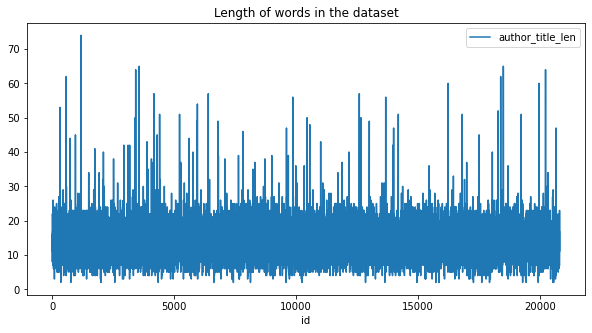

In [15]:
plt.rcParams['figure.figsize'] = [10, 5]
train_df.plot(y='author_title_len')
plt.title("Length of words in the dataset")
plt.show()

Average length of words in the dataset is 15

In [16]:
#Dataset formatting:
#train_df.drop(columns=['title','author'],inplace=True)
train_df = train_df[["author_title","author_title_len","label"]]
train_df.head()

,author_title,author_title_len,label
id,,,
0,Darrell Lucus House Dem Aide: We Didn’t Even S...,16,1
1,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...",12,0
2,Consortiumnews.com Why the Truth Might Get You...,8,1
3,Jessica Purkiss 15 Civilians Killed In Single ...,12,1
4,Howard Portnoy Iranian woman jailed for fictio...,16,1


# Check Class Imbalance

In [17]:
train_df['label'].value_counts()

0    10387
1     9855
Name: label, dtype: int64

NO Class Imbalance found

# NLP Pre-processing

In [18]:
#Remove punctuation and stop words from author_title
import string as st
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

import pickle

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)
    
def remove_stopwords(text):
    return [word for word in text.split() if word not in stopwords_dict]


In [19]:
train_df['author_title'] = train_df['author_title'].apply(lambda x: remove_punct(x))
train_df['author_title'] = train_df['author_title'].str.lower()
train_df.head()

,author_title,author_title_len,label
id,,,
0,darrell lucus house dem aide we didn’t even se...,16,1
1,daniel j flynn flynn hillary clinton big woman...,12,0
2,consortiumnewscom why the truth might get you ...,8,1
3,jessica purkiss 15 civilians killed in single ...,12,1
4,howard portnoy iranian woman jailed for fictio...,16,1


In [20]:
train_df['author_title_rem'] = train_df['author_title'].apply(lambda x : remove_stopwords(x))
train_df.head()

,author_title,author_title_len,label,author_title_rem
id,,,,
0,darrell lucus house dem aide we didn’t even se...,16,1,"[darrell, lucus, house, dem, aide, didn’t, eve..."
1,daniel j flynn flynn hillary clinton big woman...,12,0,"[daniel, j, flynn, flynn, hillary, clinton, bi..."
2,consortiumnewscom why the truth might get you ...,8,1,"[consortiumnewscom, truth, might, get, fired]"
3,jessica purkiss 15 civilians killed in single ...,12,1,"[jessica, purkiss, 15, civilians, killed, sing..."
4,howard portnoy iranian woman jailed for fictio...,16,1,"[howard, portnoy, iranian, woman, jailed, fict..."


In [21]:
train_df['author_title_rem_len'] = train_df['author_title_rem'].apply(len)
train_df.head()

,author_title,author_title_len,label,author_title_rem,author_title_rem_len
id,,,,,
0,darrell lucus house dem aide we didn’t even se...,16,1,"[darrell, lucus, house, dem, aide, didn’t, eve...",13
1,daniel j flynn flynn hillary clinton big woman...,12,0,"[daniel, j, flynn, flynn, hillary, clinton, bi...",10
2,consortiumnewscom why the truth might get you ...,8,1,"[consortiumnewscom, truth, might, get, fired]",5
3,jessica purkiss 15 civilians killed in single ...,12,1,"[jessica, purkiss, 15, civilians, killed, sing...",9
4,howard portnoy iranian woman jailed for fictio...,16,1,"[howard, portnoy, iranian, woman, jailed, fict...",12


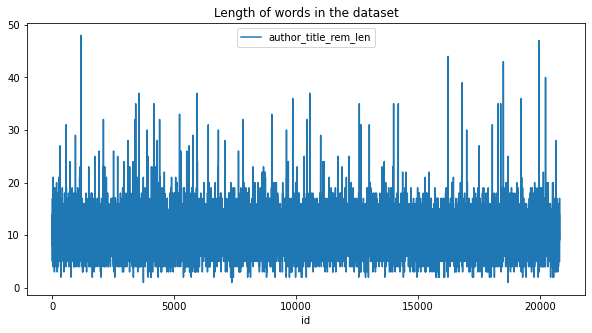

In [22]:
train_df.plot(y='author_title_rem_len')
plt.title("Length of words in the dataset")
plt.show()

Average length of words dropped to 10

In [23]:
train_df['author_title_clean'] = train_df['author_title_rem'].apply(lambda x : ' '.join([str(word) for word in x]))
train_df.head()

,author_title,author_title_len,label,author_title_rem,author_title_rem_len,author_title_clean
id,,,,,,
0,darrell lucus house dem aide we didn’t even se...,16,1,"[darrell, lucus, house, dem, aide, didn’t, eve...",13,darrell lucus house dem aide didn’t even see c...
1,daniel j flynn flynn hillary clinton big woman...,12,0,"[daniel, j, flynn, flynn, hillary, clinton, bi...",10,daniel j flynn flynn hillary clinton big woman...
2,consortiumnewscom why the truth might get you ...,8,1,"[consortiumnewscom, truth, might, get, fired]",5,consortiumnewscom truth might get fired
3,jessica purkiss 15 civilians killed in single ...,12,1,"[jessica, purkiss, 15, civilians, killed, sing...",9,jessica purkiss 15 civilians killed single us ...
4,howard portnoy iranian woman jailed for fictio...,16,1,"[howard, portnoy, iranian, woman, jailed, fict...",12,howard portnoy iranian woman jailed fictional ...


In [24]:
# Dividing the training set by using train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df['author_title_clean'], train_df.label, test_size=0.20, 
                                                    random_state=0)

In [25]:
print(X_train.shape,X_val.shape)
print(y_train.shape,y_val.shape)

(16193,) (4049,)
(16193,) (4049,)


# Vectorization

In [26]:
# Initialize the `count_vectorizer` 
#count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english') 
count_vectorizer = CountVectorizer(ngram_range=(1, 2)) 
# Fit and transform the training data.
count_train = count_vectorizer.fit_transform(X_train)
# Transform the val set 
count_val = count_vectorizer.transform(X_val)

In [27]:
#Initialize the `tfidf_vectorizer` 
#tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
#Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
#Transform the test set 
tfidf_val = tfidf_vectorizer.transform(X_val)

In [65]:
# save the vectorizer to disk
pickle.dump(count_vectorizer, open('count_vectorizer.pkl', 'wb'))

pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pkl', 'wb'))

# Plot Confusion matrix

In [29]:
# Creating a function that outputs a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Multinomial Naive Bayes Classifier - with CountVectorizer and TF-IDF

In [30]:
def tune_MNB(train,val,y_train,y_val):
    nbclassifier_alpha = 0.0
    nbclassifier_score = 0.0
    for alpha in np.arange(0,.1,.01):
        nb_classifier_tune = MultinomialNB(alpha=alpha)
        nb_classifier_tune.fit(train, y_train)
        pred_tune = nb_classifier_tune.predict(val)
        score = metrics.accuracy_score(y_val, pred_tune)
        print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
        if float(score) >= float(nbclassifier_score):
            nbclassifier_alpha = alpha
            nbclassifier_score = score
    return nbclassifier_alpha,nbclassifier_score

In [31]:
#hyperparameter tuning MNBClassifier with Count Vectorizer 
nbclassifier_count_alpha,nbclassifier_count_score = tune_MNB(count_train,count_val,y_train,y_val)
print("Best Score :", nbclassifier_count_score.round(2))        
print("Best Alpha :", nbclassifier_count_alpha.round(2))

C:\Users\anarayan\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00 Score: 0.95159
Alpha: 0.01 Score: 0.96468
Alpha: 0.02 Score: 0.96691
Alpha: 0.03 Score: 0.96814
Alpha: 0.04 Score: 0.96789
Alpha: 0.05 Score: 0.96888
Alpha: 0.06 Score: 0.96962
Alpha: 0.07 Score: 0.96962
Alpha: 0.08 Score: 0.96962
Alpha: 0.09 Score: 0.97012
Best Score : 0.97
Best Alpha : 0.09


In [32]:
#hyperparameter tuning MNBClassifier with TFIDF Vectorizer 
nbclassifier_tfidf_alpha,nbclassifier_tfidf_score = tune_MNB(tfidf_train,tfidf_val,y_train,y_val)
print("Best Score :", nbclassifier_tfidf_score.round(2))        
print("Best Alpha :", nbclassifier_tfidf_alpha.round(2))

Alpha: 0.00 Score: 0.93332
Alpha: 0.01 Score: 0.95530
Alpha: 0.02 Score: 0.95703
Alpha: 0.03 Score: 0.95752
Alpha: 0.04 Score: 0.95999
Alpha: 0.05 Score: 0.96048
Alpha: 0.06 Score: 0.96024
Alpha: 0.07 Score: 0.96073
Alpha: 0.08 Score: 0.96098
Alpha: 0.09 Score: 0.96098
Best Score : 0.96
Best Alpha : 0.09


C:\Users\anarayan\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [33]:
def use_best_alpha(alpha,train,y_train,val,y_val,title):
    nb_classifier = MultinomialNB(alpha = alpha.round(2))
    nb_classifier.fit(train, y_train)
    pred_nb = nb_classifier.predict(val)
    acc_nb = metrics.accuracy_score(y_val, pred_nb)
    print("Accuracy - MNB :",acc_nb)
    cm = metrics.confusion_matrix(y_val, pred_nb, labels=[0,1])
    plot_confusion_matrix(cm, classes=['TRUE','FALSE'], title = title)
    return nb_classifier,pred_nb,acc_nb

Accuracy - MNB : 0.9701160780439615


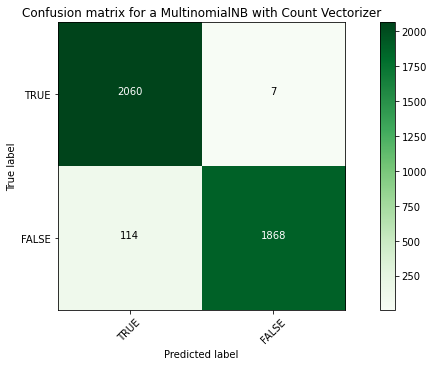

In [34]:
# optimized model with best alpha score - MNBClassifier with CountVectorizer
nb_classifier_count, pred_nb_count,acc_nb_count = use_best_alpha(nbclassifier_count_alpha,count_train,y_train,count_val,y_val,'Confusion matrix for a MultinomialNB with Count Vectorizer')

Accuracy - MNB : 0.9609780192640158


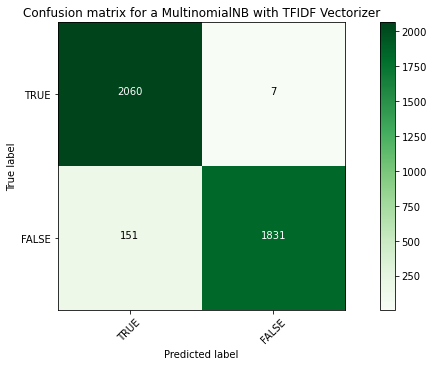

In [35]:
# optimized model with best alpha score - MNBClassifier with TFIDF Vectorizer
nb_classifier_tfidf,pred_nb_tfidf,acc_nb_tfidf = use_best_alpha(nbclassifier_tfidf_alpha,tfidf_train,y_train,tfidf_val,y_val,'Confusion matrix for a MultinomialNB with TFIDF Vectorizer')

# Logistic Regression - with CountVectorizer and TF-IDF

In [36]:
def logistic_reg(train,val,y_train,y_val,title):
    logreg = LogisticRegression(C=1e5)
    logreg.fit(train, y_train)
    pred_logreg = logreg.predict(val)
    acc_logreg = metrics.accuracy_score(y_val,pred_logreg)
    print("Accuracy - LR with CountVectorizer :",acc_logreg)
    cm = metrics.confusion_matrix(y_val, pred_logreg, labels=[0,1])
    plot_confusion_matrix(cm, classes=['TRUE','FALSE'], title=title)
    return logreg,pred_logreg,acc_logreg

Accuracy - LR with CountVectorizer : 0.9916028649049148


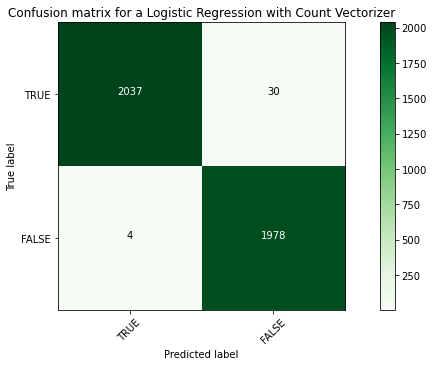

In [37]:
#Logistic Regression with Count Vectorizer
logreg_count,pred_logreg_count,acc_logreg_count = logistic_reg(count_train,count_val,y_train,y_val,
                                                  'Confusion matrix for a Logistic Regression with Count Vectorizer')

C:\Users\anarayan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy - LR with CountVectorizer : 0.9962953815756977


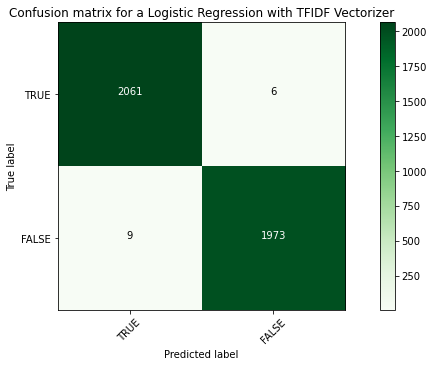

In [38]:
#Logistic Regression with TF-IDF Vectorizer
logreg_tfidf,pred_logreg_tfidf,acc_logreg_tfidf = logistic_reg(tfidf_train,tfidf_val,y_train,y_val,
                                                  'Confusion matrix for a Logistic Regression with TFIDF Vectorizer')

# Processing and Testing - X_test file

In [39]:
test_df = pd.read_csv('./Fake_news_data/test.csv',index_col='id')
test_df.head()

,title,author,text
id,,,
20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [40]:
#Preproces the test data similar to Train data
def process_df(test_df):
    test_df.fillna(' ',inplace=True)
    test_df['author_title'] = test_df['author'] + ' ' + test_df['title']
    test_df['author_title'] = test_df['author_title'].apply(lambda x: remove_punct(x))
    test_df['author_title'] = test_df['author_title'].str.lower()
    test_df['author_title'] = test_df['author_title'].apply(lambda x : remove_stopwords(x))
    test_df['author_title_clean'] = test_df['author_title'].apply(lambda x : ' '.join([str(word) for word in x]))
    df = test_df[['author_title_clean']]
    return df
df = process_df(test_df)
df.head()

,author_title_clean
id,
20800,david streitfeld specter trump loosens tongues...
20801,russian warships ready strike terrorists near ...
20802,common dreams nodapl native american leaders v...
20803,daniel victor tim tebow attempt another comeba...
20804,truth broadcast network keiser report meme war...


In [41]:
X_test = df.squeeze()
print(X_test.shape)
X_test

(5200,)


id
20800    david streitfeld specter trump loosens tongues...
20801    russian warships ready strike terrorists near ...
20802    common dreams nodapl native american leaders v...
20803    daniel victor tim tebow attempt another comeba...
20804    truth broadcast network keiser report meme war...
                               ...                        
25995    jody rosen bangladeshi traffic jam never ends ...
25996    sheryl gay stolberg john kasich signs one abor...
25997    mike mcphate california today exactly sushi ne...
25998        300 us marines deployed russian border norway
25999      teddy wayne awkward sex onscreen new york times
Name: author_title_clean, Length: 5200, dtype: object

In [68]:
tfidf_vector = pickle.load(open("tfidf_vectorizer.pkl","rb"))
count_vector = pickle.load(open("count_vectorizer.pkl","rb"))

In [69]:
#tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf_test = tfidf_vector.transform(X_test)
#count_test = count_vectorizer.transform(X_test)
count_test = count_vector.transform(X_test)

# Applying different algorithms on Test file

In [70]:
X_pred_logreg_tfidf = logreg_tfidf.predict(tfidf_test)
print(np.unique(X_pred_logreg_tfidf,return_counts=True))

(array([0, 1], dtype=int64), array([2615, 2585], dtype=int64))


In [71]:
X_pred_logreg_count = logreg_count.predict(count_test)
print(np.unique(X_pred_logreg_count,return_counts=True))

(array([0, 1], dtype=int64), array([2596, 2604], dtype=int64))


In [72]:
X_pred_nb_classifier_tfidf = nb_classifier_tfidf.predict(tfidf_test)
print(np.unique(X_pred_nb_classifier_tfidf,return_counts=True))

(array([0, 1], dtype=int64), array([2896, 2304], dtype=int64))


In [73]:
X_pred_nb_classifier_count = nb_classifier_count.predict(count_test)
print(np.unique(X_pred_nb_classifier_count,return_counts=True))

(array([0, 1], dtype=int64), array([2859, 2341], dtype=int64))


# Submission

In [74]:
submit_df = pd.read_csv('./Fake_news_data/submit.csv',index_col='id')
submit_df.head()

,label
id,
20800,0
20801,1
20802,0
20803,1
20804,1


In [75]:
submit_df['logreg_tfidf'] = X_pred_logreg_tfidf
submit_df['logreg_count'] = X_pred_logreg_count
submit_df['nbclassifier_tfidf'] = X_pred_nb_classifier_tfidf
submit_df['nbclassifier_count'] = X_pred_nb_classifier_count

In [76]:
submit_df

,label,logreg_tfidf,logreg_count,nbclassifier_tfidf,nbclassifier_count
id,,,,,
20800,0,0,0,0,0
20801,1,1,1,1,1
20802,0,1,1,1,1
20803,1,0,0,0,0
20804,1,1,1,1,1
...,...,...,...,...,...
25995,0,0,0,0,0
25996,1,0,0,0,0
25997,0,0,0,0,0


In [77]:
submit_df.to_csv('submission.csv')

In [78]:
def accuracy_check(y_pred,y_actual):
    accuracy = metrics.accuracy_score(y_pred,y_actual)
    return accuracy

In [79]:
accuracy_logreg_tfidf = accuracy_check(submit_df['logreg_tfidf'],submit_df['label'])
print(accuracy_logreg_tfidf)

accuracy_logreg_count = accuracy_check(submit_df['logreg_count'],submit_df['label'])
print(accuracy_logreg_count)

accuracy_nbclassifier_tfidf = accuracy_check(submit_df['nbclassifier_tfidf'],submit_df['label'])
print(accuracy_nbclassifier_tfidf)

accuracy_nbclassifier_count = accuracy_check(submit_df['nbclassifier_count'],submit_df['label'])
print(accuracy_nbclassifier_count)

0.6357692307692308
0.6363461538461539
0.604423076923077
0.6092307692307692


In [80]:
# save the model to disk
pickle.dump(logreg_count, open("final_model.pkl", 'wb'))

# Testing the model by loading from disk

In [81]:
# load the model from disk
load_model = pickle.load(open("final_model.pkl", 'rb'))
check = load_model.predict(count_test)
print(np.unique(check,return_counts=True))

(array([0, 1], dtype=int64), array([2596, 2604], dtype=int64))


# Single Entry Testing for App

In [82]:
title1 = 'â€˜Age of Empiresâ€™: How 2 Dynasties of Art Forged Chinaâ€™s Identity - The New York Times'
author1 = 'Holland Cotter'
text1 = 'No one does epic better than the Metropolitan Museum of Art'

In [83]:
author_title1 = author1 + ' ' + title1
author_title1 = author_title1.lower()
author_title1 = "".join([ch for ch in author_title1 if ch not in st.punctuation])
author_title1 = [word for word in author_title1.split() if word not in stopwords_dict]
author_title_clean1 = ' '.join([str(word) for word in author_title1])

In [85]:
check_model = pickle.load(open("final_model.pkl", "rb"))
check_vector = pickle.load(open("count_vectorizer.pkl","rb"))

In [87]:
text_list1 = [author_title_clean1]
text_tfidf1 = check_vector.transform(text_list1)
check_model.predict(text_tfidf1)

array([0], dtype=int64)